Basic imports beforehand

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's grab our cleaned data and put it in a pandas DataFrame. Let's remove the games that were terminated early because one of the players was cheating, as these games aren't fair and shouldn't be considered in our analysis.

In [2]:
data = pd.read_pickle('./Chess_Data.pickle').astype({'Game Type': 'category', 'Result': 'category', 'White ELO': 'uint16', 'Black ELO': 'uint16', 'Time Control': 'string', 'Termination': 'category', 'Moves': 'uint8'})
# drop any game that terminated with 'rules infraction'
data.drop(data.loc[data['Termination'] == 'Rules infraction'].index, inplace=True)
data.head()

,Game Type,Result,White ELO,Black ELO,Time Control,Termination,Moves
0,Blitz,1-0,1577,1383,300+0,Normal,24
1,Classical,1-0,1750,1696,900+5,Normal,37
2,Classical,1-0,1499,1135,1200+0,Time forfeit,10
3,Bullet,0-1,1296,1441,0+1,Time forfeit,2
4,Blitz,0-1,1730,1851,300+0,Abandoned,0


Let's begin by visualizing how many games are won by white, how many games are won by black, and how many games are draws.

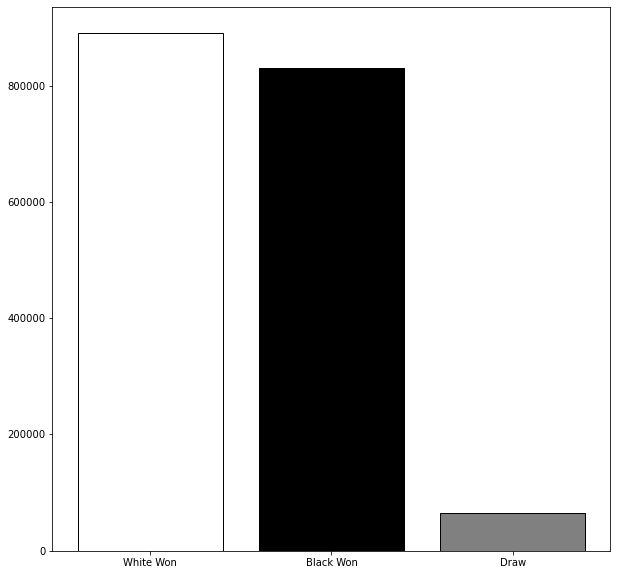

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar('White Won', len(data.loc[data['Result'] == '1-0']), color='white', edgecolor='black')
ax.bar('Black Won', len(data.loc[data['Result'] == '0-1']), color='black', edgecolor='black')
ax.bar('Draw', len(data.loc[data['Result'] == '1/2-1/2']), color='gray', edgecolor='black');

That gives us an idea of the overall chances of white winning versus black winning, but lets break it down a bit and see if there is a difference between each type of game (note the difference in y-axis scales, this is because we have different numbers of each game).

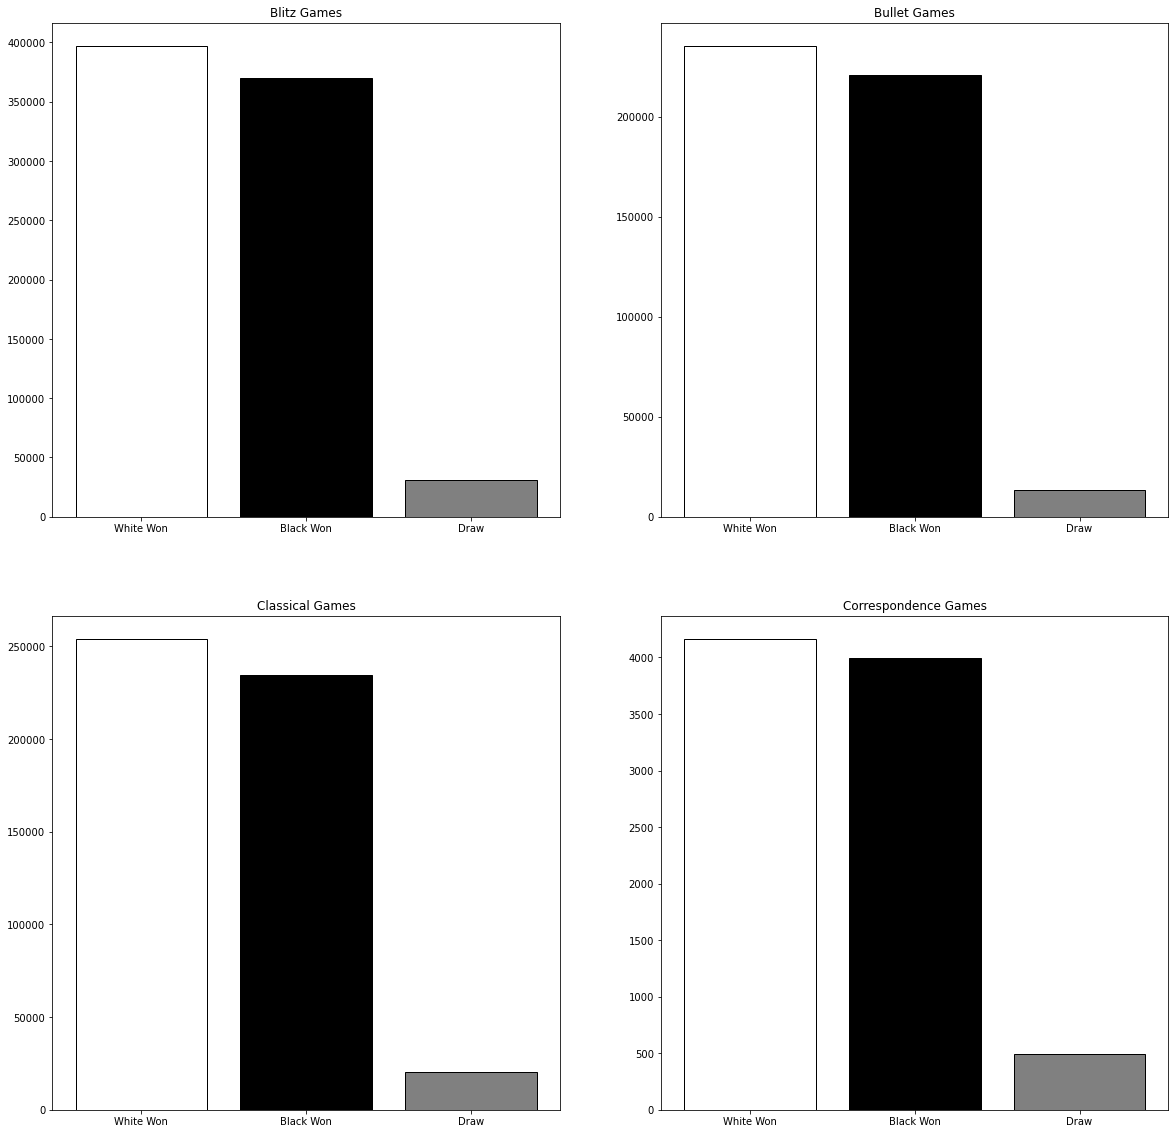

In [4]:
labels = np.unique(data['Game Type'])
whiteWon0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '1-0')])
blackWon0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '0-1')])
draw0 = len(data.loc[(data['Game Type'] == labels[0]) & (data['Result'] == '1/2-1/2')])
whiteWon1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '1-0')])
blackWon1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '0-1')])
draw1 = len(data.loc[(data['Game Type'] == labels[1]) & (data['Result'] == '1/2-1/2')])
whiteWon2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '1-0')])
blackWon2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '0-1')])
draw2 = len(data.loc[(data['Game Type'] == labels[2]) & (data['Result'] == '1/2-1/2')])
whiteWon3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '1-0')])
blackWon3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '0-1')])
draw3 = len(data.loc[(data['Game Type'] == labels[3]) & (data['Result'] == '1/2-1/2')])

fig, axs = plt.subplots(2, 2, figsize=(20,20))
axs[0,0].bar('White Won', whiteWon0, color='white', edgecolor='black')
axs[0,0].bar('Black Won', blackWon0, color='black', edgecolor='black')
axs[0,0].bar('Draw', draw0, color='gray', edgecolor='black')
axs[0,0].set_title('Blitz Games')
axs[0,1].bar('White Won', whiteWon1, color='white', edgecolor='black')
axs[0,1].bar('Black Won', blackWon1, color='black', edgecolor='black')
axs[0,1].bar('Draw', draw1, color='gray', edgecolor='black')
axs[0,1].set_title('Bullet Games')
axs[1,0].bar('White Won', whiteWon2, color='white', edgecolor='black')
axs[1,0].bar('Black Won', blackWon2, color='black', edgecolor='black')
axs[1,0].bar('Draw', draw2, color='gray', edgecolor='black')
axs[1,0].set_title('Classical Games')
axs[1,1].bar('White Won', whiteWon3, color='white', edgecolor='black')
axs[1,1].bar('Black Won', blackWon3, color='black', edgecolor='black')
axs[1,1].bar('Draw', draw3, color='gray', edgecolor='black')
axs[1,1].set_title('Correspondence Games');

What info can we draw from these graphs? It appears that the same general trend still applies to the stratified data. Maybe the ELO of the players makes a difference?

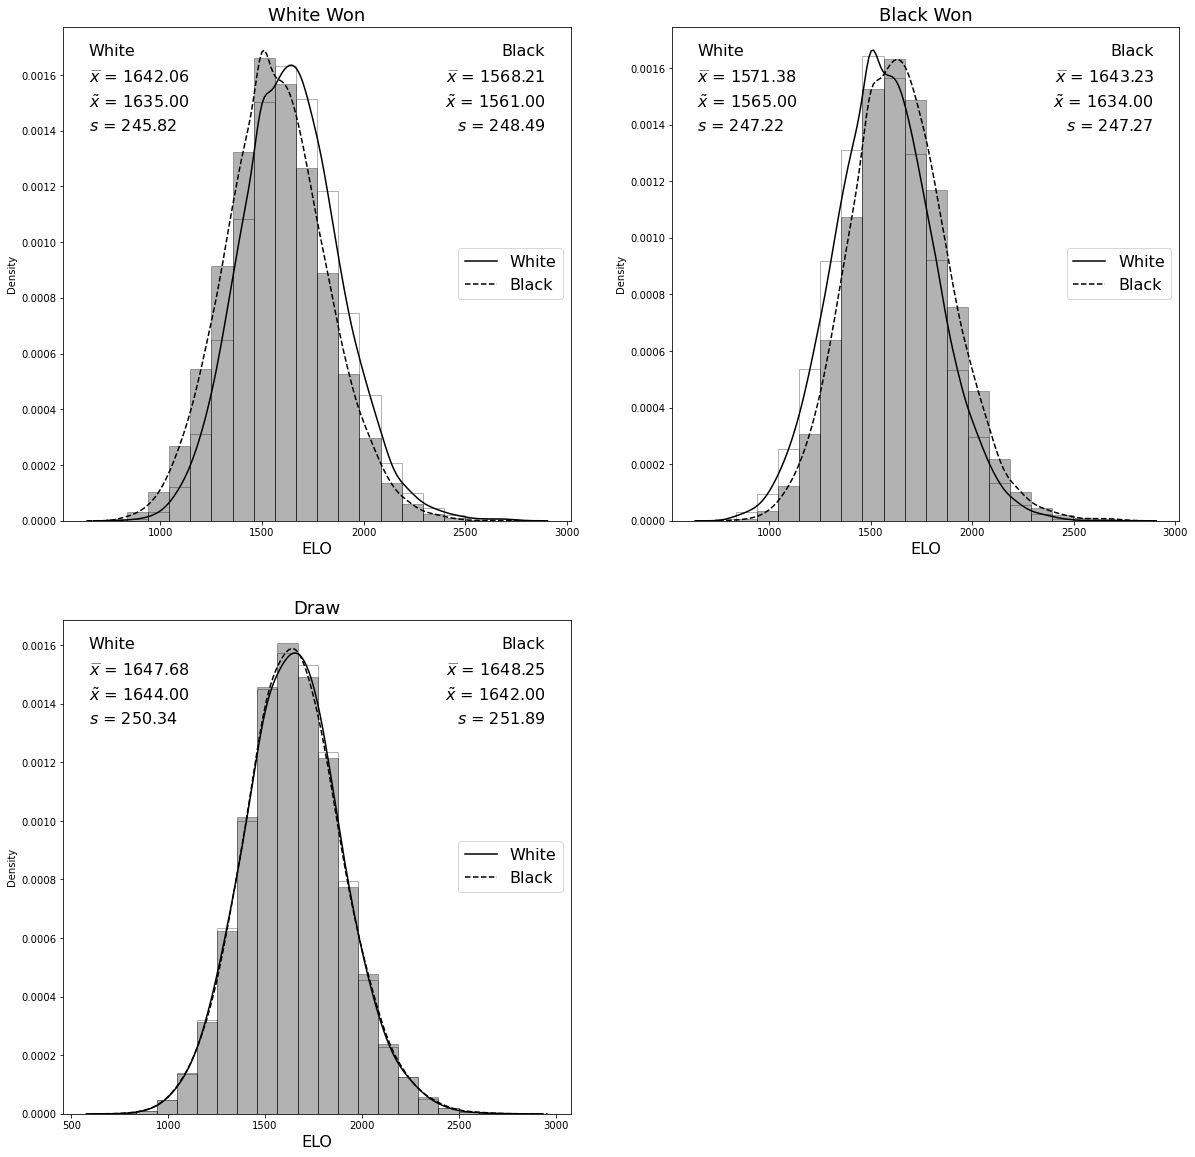

In [5]:
# in the cleaning code, any ELO of '?' was set to 0, we should remove these values because they aren't actually 0s
data.drop(data.loc[(data['White ELO'] == 0) | (data['Black ELO'] == 0)].index, inplace=True)
whiteWonELOs = data.loc[data['Result'] == '1-0', ['Black ELO', 'White ELO']]
blackWonELOs = data.loc[data['Result'] == '0-1', ['Black ELO', 'White ELO']]
drawELOs = data.loc[data['Result'] == '1/2-1/2', ['Black ELO', 'White ELO']]
# set the range so every histogram looks the same
r = (min(np.min(data['White ELO']), np.min(data['Black ELO'])), max(np.max(data['White ELO']), np.max(data['Black ELO'])))

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.delaxes(axs[1,1])

# draw histograms of every ELO and overlay kernel density estimation lines
axs[0,0].hist(whiteWonELOs['White ELO'], bins=20, range=r, density=True, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=whiteWonELOs, x='White ELO', bw_adjust=2, ax=axs[0,0], label='White', color='black')
axs[0,0].hist(whiteWonELOs['Black ELO'], bins=20, range=r, density=True, color='black', edgecolor='black', alpha=0.3)
sns.kdeplot(data=whiteWonELOs, x='Black ELO', bw_adjust=2, ax=axs[0,0], label='Black', color='black', linestyle='dashed')
axs[0,1].hist(blackWonELOs['White ELO'], bins=20, range=r, density=True, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=blackWonELOs, x='White ELO', bw_adjust=2, ax=axs[0,1], label='White', color='black')
axs[0,1].hist(blackWonELOs['Black ELO'], bins=20, range=r, density=True, color='black', edgecolor='black', alpha=0.3)
sns.kdeplot(data=blackWonELOs, x='Black ELO', bw_adjust=2, ax=axs[0,1], label='Black', color='black', linestyle='dashed')
axs[1,0].hist(drawELOs['White ELO'], bins=20, range=r, density=True, color='white', edgecolor='black', alpha=0.3)
sns.kdeplot(data=drawELOs, x='White ELO', bw_adjust=2, ax=axs[1,0], label='White', color='black')
axs[1,0].hist(drawELOs['Black ELO'], bins=20, range=r, density=True, color='black', edgecolor='black', alpha=0.3)
sns.kdeplot(data=drawELOs, x='Black ELO', bw_adjust=2, ax=axs[1,0], label='Black', color='black', linestyle='dashed')

# add titles and labels to make graphs more informative
axs[0,0].set_title('White Won', fontsize=18)
axs[0,0].set_xlabel('ELO', fontsize=16)
axs[0,0].text(0.05, 0.95, 'White', transform=axs[0,0].transAxes, horizontalalignment='left',\
     verticalalignment='center', fontsize=16)
axs[0,0].text(0.05, 0.9, f"$\widebar{{x}}$ = {np.mean(whiteWonELOs['White ELO']):.2f}",\
     transform=axs[0,0].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,0].text(0.05, 0.85, fr"$\tilde{{x}}$ = {np.median(whiteWonELOs['White ELO']):.2f}",\
     transform=axs[0,0].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,0].text(0.05, 0.8, f"$s$ = {np.std(whiteWonELOs['White ELO']):.2f}", transform=axs[0,0].transAxes,\
     horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,0].text(0.95, 0.95, 'Black', transform=axs[0,0].transAxes, horizontalalignment='right',\
     verticalalignment='center', fontsize=16)
axs[0,0].text(0.95, 0.9, f"$\widebar{{x}}$ = {np.mean(whiteWonELOs['Black ELO']):.2f}",\
     transform=axs[0,0].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,0].text(0.95, 0.85, fr"$\tilde{{x}}$ = {np.median(whiteWonELOs['Black ELO']):.2f}",\
     transform=axs[0,0].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,0].text(0.95, 0.8, f"$s$ = {np.std(whiteWonELOs['Black ELO']):.2f}", transform=axs[0,0].transAxes,\
     horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,0].legend(loc='center right', fontsize=16)

# add titles and labels to make graphs more informative
axs[0,1].set_title('Black Won', fontsize=18)
axs[0,1].set_xlabel('ELO', fontsize=16)
axs[0,1].text(0.05, 0.95, 'White', transform=axs[0,1].transAxes, horizontalalignment='left',\
     verticalalignment='center', fontsize=16)
axs[0,1].text(0.05, 0.9, f"$\widebar{{x}}$ = {np.mean(blackWonELOs['White ELO']):.2f}",\
     transform=axs[0,1].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,1].text(0.05, 0.85, fr"$\tilde{{x}}$ = {np.median(blackWonELOs['White ELO']):.2f}",\
     transform=axs[0,1].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,1].text(0.05, 0.8, f"$s$ = {np.std(blackWonELOs['White ELO']):.2f}", transform=axs[0,1].transAxes,\
     horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[0,1].text(0.95, 0.95, 'Black', transform=axs[0,1].transAxes, horizontalalignment='right',\
     verticalalignment='center', fontsize=16)
axs[0,1].text(0.95, 0.9, f"$\widebar{{x}}$ = {np.mean(blackWonELOs['Black ELO']):.2f}",\
     transform=axs[0,1].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,1].text(0.95, 0.85, fr"$\tilde{{x}}$ = {np.median(blackWonELOs['Black ELO']):.2f}",\
     transform=axs[0,1].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,1].text(0.95, 0.8, f"$s$ = {np.std(blackWonELOs['Black ELO']):.2f}", transform=axs[0,1].transAxes,\
     horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[0,1].legend(loc='center right', fontsize=16)

# add titles and labels to make graphs more informative
axs[1,0].set_title('Draw', fontsize=18)
axs[1,0].set_xlabel('ELO', fontsize=16)
axs[1,0].text(0.05, 0.95, 'White', transform=axs[1,0].transAxes, horizontalalignment='left',\
     verticalalignment='center', fontsize=16)
axs[1,0].text(0.05, 0.9, f"$\widebar{{x}}$ = {np.mean(drawELOs['White ELO']):.2f}",\
     transform=axs[1,0].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[1,0].text(0.05, 0.85, fr"$\tilde{{x}}$ = {np.median(drawELOs['White ELO']):.2f}",\
     transform=axs[1,0].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[1,0].text(0.05, 0.8, f"$s$ = {np.std(drawELOs['White ELO']):.2f}", transform=axs[1,0].transAxes,\
     horizontalalignment='left', verticalalignment='center', fontsize=16)
axs[1,0].text(0.95, 0.95, 'Black', transform=axs[1,0].transAxes, horizontalalignment='right',\
     verticalalignment='center', fontsize=16)
axs[1,0].text(0.95, 0.9, f"$\widebar{{x}}$ = {np.mean(drawELOs['Black ELO']):.2f}",\
     transform=axs[1,0].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[1,0].text(0.95, 0.85, fr"$\tilde{{x}}$ = {np.median(drawELOs['Black ELO']):.2f}",\
     transform=axs[1,0].transAxes, horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[1,0].text(0.95, 0.8, f"$s$ = {np.std(drawELOs['Black ELO']):.2f}", transform=axs[1,0].transAxes,\
     horizontalalignment='right', verticalalignment='center', fontsize=16)
axs[1,0].legend(loc='center right', fontsize=16);

Of course, this method of looking at ELOs erases the paired nature of the data, so let's add a new column with the ELO difference between the two players, measured as `White ELO - Black ELO`. We can then analyze these differences along with who won to try to find a better idea of the correlation.

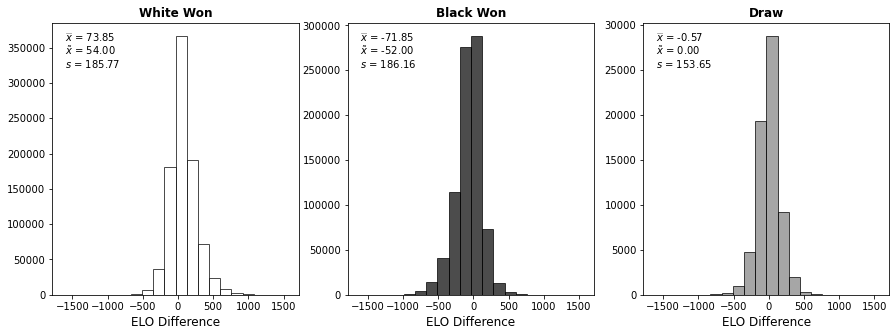

In [31]:
data['ELO Difference'] = (data['White ELO'] - data['Black ELO']).astype('int16')
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
r = (np.min(data['ELO Difference']), np.max(data['ELO Difference']))

axs[0].hist(data.loc[data['Result'] == '1-0']['ELO Difference'], bins=20, range=r, color='white', edgecolor='black', alpha=0.7)
axs[1].hist(data.loc[data['Result'] == '0-1']['ELO Difference'], bins=20, range=r, color='black', edgecolor='black', alpha=0.7)
axs[2].hist(data.loc[data['Result'] == '1/2-1/2']['ELO Difference'], bins=20, range=r, color='gray', edgecolor='black', alpha=0.7)

def add_info(ax, pNum, result, title):
     ax[pNum].set_title(title, fontsize='large', fontweight='bold')
     ax[pNum].set_xlabel('ELO Difference', fontsize='large')
     ax[pNum].text(0.05, 0.95, f"$\widebar{{x}}$ = {np.mean(data.loc[data['Result'] == result]['ELO Difference']):.2f}",\
          transform=ax[pNum].transAxes, horizontalalignment='left', verticalalignment='center', fontsize='medium')
     ax[pNum].text(0.05, 0.9, fr"$\tilde{{x}}$ = {np.median(data.loc[data['Result'] == result]['ELO Difference']):.2f}",\
          transform=ax[pNum].transAxes, horizontalalignment='left', verticalalignment='center', fontsize='medium')
     ax[pNum].text(0.05, 0.85, f"$s$ = {np.std(data.loc[data['Result'] == result]['ELO Difference']):.2f}",\
          transform=ax[pNum].transAxes, horizontalalignment='left', verticalalignment='center', fontsize='medium')

add_info(axs, 0, '1-0', 'White Won')
add_info(axs, 1, '0-1', 'Black Won')
add_info(axs, 2, '1/2-1/2', 'Draw');

Now let's combine the ELO Difference with Game Type to see if there might be an interaction between these two variables.

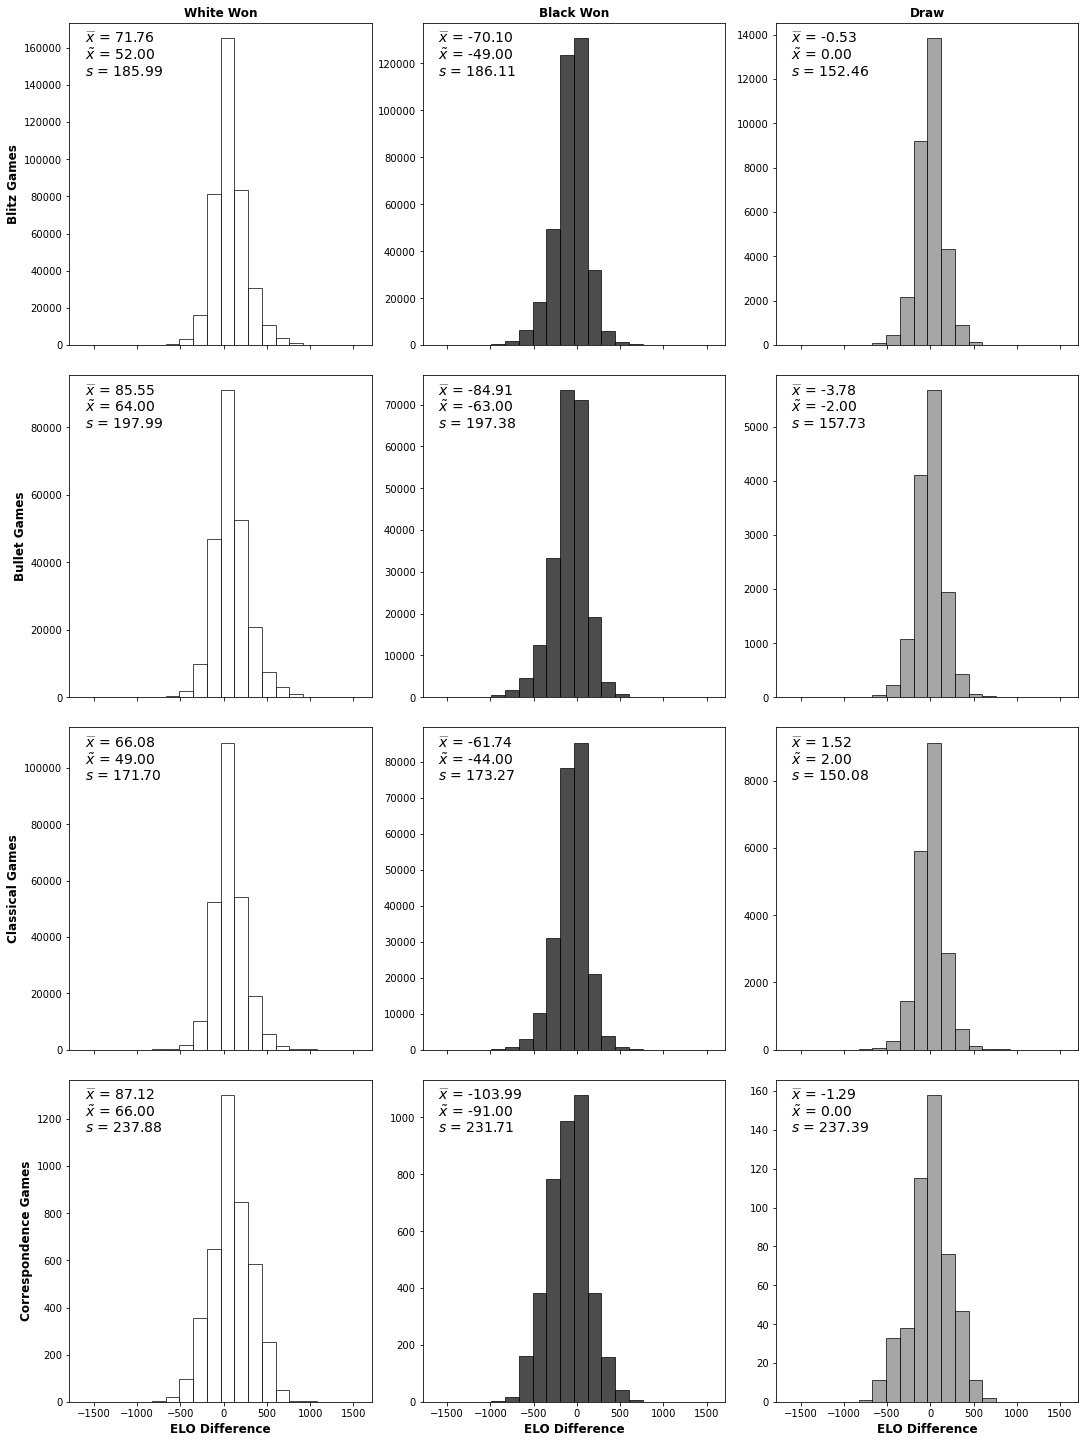

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharex=True)
fig.tight_layout(pad=2)
gameTypes = ['Blitz', 'Bullet', 'Classical', 'Correspondence']
results = ['1-0', '0-1', '1/2-1/2']
colors = ['white', 'black', 'gray']
r = (np.min(data['ELO Difference']), np.max(data['ELO Difference']))

for i in range(4):
    for j in range(3):
        axs[i,j].hist(data.loc[(data['Game Type'] == gameTypes[i]) & (data['Result'] == results[j])]['ELO Difference'],\
             bins=20, range=r, color=colors[j], edgecolor='black', alpha=0.7)
        axs[i,j].text(0.05, 0.95, f"$\widebar{{x}}$ = {np.mean(data.loc[(data['Game Type'] == gameTypes[i]) & (data['Result'] == results[j])]['ELO Difference']):.2f}",\
             transform=axs[i,j].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=14)
        axs[i,j].text(0.05, 0.9, rf"$\tilde{{x}}$ = {np.median(data.loc[(data['Game Type'] == gameTypes[i]) & (data['Result'] == results[j])]['ELO Difference']):.2f}",\
             transform=axs[i,j].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=14)
        axs[i,j].text(0.05, 0.85, f"$s$ = {np.std(data.loc[(data['Game Type'] == gameTypes[i]) & (data['Result'] == results[j])]['ELO Difference']):.2f}",\
             transform=axs[i,j].transAxes, horizontalalignment='left', verticalalignment='center', fontsize=14)

axs[0,0].set_title('White Won', fontweight='bold', size='large')
axs[0,1].set_title('Black Won', fontweight='bold', size='large')
axs[0,2].set_title('Draw', fontweight='bold', size='large')
axs[0,0].set_ylabel('Blitz Games', fontweight='bold', size='large')
axs[1,0].set_ylabel('Bullet Games', fontweight='bold', size='large')
axs[2,0].set_ylabel('Classical Games', fontweight='bold', size='large')
axs[3,0].set_ylabel('Correspondence Games', fontweight='bold', size='large')
axs[3,0].set_xlabel('ELO Difference', fontweight='bold', size='large')
axs[3,1].set_xlabel('ELO Difference', fontweight='bold', size='large')
axs[3,2].set_xlabel('ELO Difference', fontweight='bold', size='large');